# EPA1361 - Model-Based Decision Making
# Week 3 - Sensitivity analysis

This exercise uses the same predator-prey model we used for the multi-model exercise, focusing on the Python version. As with the other exercise, define a model object for the function below, with the uncertainty ranges provided:

|Parameter	|Range or value	        |
|-----------|--------------:|
|prey_birth_rate    	|0.015 – 0.035	|
|predation_rate|0.0005 – 0.003 	|
|predator_efficiency     	|0.001 – 0.004	    |
|predator_loss_rate	    |0.04 – 0.08	    |

* Sensitivity analysis often focuses on the final values of an outcome at the end of the simulation. However, we can also look at metrics that give us additional information about the behavior of the model over time. Using [the statsmodel library](https://www.statsmodels.org/stable/index.html) and an appropriate sampling design, fit a linear regression model for each of the following indicators. What can we conclude about the behavior of the model, and about the importance of the different inputs?

  * The final values of the _prey_ outcome
  * The mean values of the _prey_ outcome over time, within each experiment
  * The standard deviations of the _prey_ outcome over time, within each experiment
  

* Use the Sobol sampling functionality included in the Workbench to perform experiments with a sample size of N=50, then analyze the results with SALib for the same three indicators. This requires specifying the keyword argument `'uncertainty_sampling'` of perform_experiments. Note that when using Sobol sampling, the meaning of the keyword argument `scenarios` changes a bit. In order to properly estimate Sobol scores as well as interaction effects, you require N * (2D+2) scenarios, where D is the number of uncertain parameters, and N is the value for scenarios passed to `perform_experiments`. Repeat the analysis for larger sample sizes, with N=250 and N=1000. How can we interpret the first-order and total indices? Are these sample sizes sufficient for a stable estimation of the indices? You'll need to use the [get_SALib_problem](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/em_framework/salib_samplers.html) function to convert your Workbench experiments to a problem definition that you can pass to the SALib analysis function. 

* *hint*: sobol is a deterministic sequence of quasi random numbers. Thus, you can run with N=1000 and simply slice for 1:50 and 1:250.

* Use the [Extra-Trees analysis](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/feature_scoring.html) included in the Workbench to approximate the Sobol total indices, with a suitable sampling design. As a starting point, use an ensemble of 100 trees and a max_features parameter of 0.6, and set the analysis to regression mode. Are the estimated importances stable relative to the sample size and the analysis parameters? How do the results compare to the Sobol indices? For more details on this analysis see [Jaxa-Rozen & Kwakkel (2018)](https://www.sciencedirect.com/science/article/pii/S1364815217311581)

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from ema_workbench import (Model, RealParameter, TimeSeriesOutcome, perform_experiments, ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from SALib.analyze import sobol

from predprey_function import pred_prey

C:\Users\Ashok\Anaconda3\lib\site-packages\ema_workbench\em_framework\evaluators.py:22: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  'ipyparallel not installed - IpyparalleEvaluator not available')
C:\Users\Ashok\Anaconda3\lib\site-packages\ema_workbench\em_framework\optimization.py:48: ImportWarning: platypus based optimization not available
  warnings.warn("platypus based optimization not available", ImportWarning)


# Model Definition and Experiments


In [2]:
#Initiate Model
model = Model(name="PredPreyModel", function = pred_prey)

#Define Uncertainties
model.uncertainties = [RealParameter('prey_birth_rate', 0.015 , 0.035),
                       RealParameter('predation_rate', 0.0005 , 0.003),
                       RealParameter('predator_efficiency', 0.001 , 0.004),
                       RealParameter('predator_loss_rate', 0.04 , 0.08)]

#Define Outcomes
model.outcomes = [TimeSeriesOutcome('TIME'),
                  TimeSeriesOutcome('predators'),
                  TimeSeriesOutcome('prey')]

#Turn on logging
ema_logging.log_to_stderr(ema_logging.INFO)

n_scenarios = 100

with MultiprocessingEvaluator(model, n_processes=7) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(n_scenarios)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 100 scenarios * 1 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [3]:
experiments

,predation_rate,predator_efficiency,predator_loss_rate,prey_birth_rate,scenario,policy,model
0,0.000540,0.001721,0.060539,0.025085,0,None,PredPreyModel
1,0.001839,0.003663,0.072066,0.022405,1,None,PredPreyModel
2,0.001824,0.001647,0.077572,0.027338,2,None,PredPreyModel
3,0.001362,0.001530,0.046779,0.021367,3,None,PredPreyModel
4,0.002634,0.002918,0.070171,0.017638,4,None,PredPreyModel
5,0.001297,0.002223,0.062524,0.026560,5,None,PredPreyModel
6,0.002996,0.003633,0.040914,0.024642,6,None,PredPreyModel
7,0.002323,0.002580,0.060989,0.032089,7,None,PredPreyModel
8,0.001502,0.003795,0.078785,0.032413,8,None,PredPreyModel
9,0.000946,0.002450,0.069608,0.022019,9,None,PredPreyModel


## Linear regression

In [4]:
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf

experiments_clean = experiments.drop(columns=['scenario','policy','model'])

experiments_clean.values.dtype


dtype('float64')

In [5]:
#create the right dataframe
prey = outcomes['prey']
prey

array([[[50.        , 50.1786847 , 50.35714383, ..., 63.13043764,
         63.12329785, 63.11130879]],

       [[50.        , 49.82033004, 49.62858277, ..., 36.90028147,
         37.0901315 , 37.28069125]],

       [[50.        , 49.8857647 , 49.77124506, ..., 51.98111778,
         52.07964544, 52.17784165]],

       ...,

       [[50.        , 50.09779551, 50.18951776, ..., 23.05911182,
         23.20993923, 23.36170164]],

       [[50.        , 49.92301665, 49.84229111, ..., 21.83196435,
         21.90364976, 21.97614642]],

       [[50.        , 49.94233958, 49.87540906, ..., 51.61028648,
         51.74439569, 51.87344276]]])

In [6]:
prey_mean = np.mean(outcomes['prey'][:,0,:], axis=1)
prey_mean

LR_mean = statsmodels.regression.linear_model.OLS(prey_mean, experiments_clean.values)

fitted_mean = LR_mean.fit()

fitted_mean.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.957
Model:                            OLS   Adj. R-squared (uncentered):              0.956
Method:                 Least Squares   F-statistic:                              538.6
Date:                Fri, 15 May 2020   Prob (F-statistic):                    8.17e-65
Time:                        11:47:26   Log-Likelihood:                         -324.71
No. Observations:                 100   AIC:                                      657.4
Df Residuals:                      96   BIC:                                      667.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           968.6672    852.670      1.136      0.259    -723.870    2661.204
x2         -1.208e+04    750.443    -16.093      0.000   -1.36e+04   -1.06e+04
x3           753.8808     39.009     19.326      0.000     676.448     831.313
x4           382.0868     96.818      3.946      0.000     189.905     574.269
==============================================================================
Omnibus:                        5.496   Durbin-Watson:                   2.489
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                4.892
Skew:                           0.515   Prob(JB):                       0.0866
Kurtosis:                       3.336   Cond. No.                         93.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
prey_final = outcomes['prey'][:,:,-1].flatten()
prey_final

LR_final = statsmodels.regression.linear_model.OLS(prey_final, experiments_clean.values)

fitted_final = LR_final.fit()


fitted_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.816
Model:                            OLS   Adj. R-squared (uncentered):              0.809
Method:                 Least Squares   F-statistic:                              106.8
Date:                Fri, 15 May 2020   Prob (F-statistic):                    1.83e-34
Time:                        11:47:26   Log-Likelihood:                         -418.87
No. Observations:                 100   AIC:                                      845.7
Df Residuals:                      96   BIC:                                      856.2
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -2867.0535   2186.353     -1.311      0.193   -7206.931    1472.824
x2         -1.107e+04   1924.230     -5.756      0.000   -1.49e+04   -7255.405
x3           917.2398    100.025      9.170      0.000     718.693    1115.787
x4           321.6891    248.253      1.296      0.198    -171.090     814.468
==============================================================================
Omnibus:                       17.620   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.926
Skew:                           0.787   Prob(JB):                     1.42e-06
Kurtosis:                       4.996   Cond. No.                         93.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
prey_std = np.std(outcomes['prey'][:,0,:], axis=1)
prey_std

LR_std = statsmodels.regression.linear_model.OLS(prey_std, experiments_clean.values)

fitted_std = LR_std.fit()


fitted_std.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.921
Model:                            OLS   Adj. R-squared (uncentered):              0.918
Method:                 Least Squares   F-statistic:                              279.6
Date:                Fri, 15 May 2020   Prob (F-statistic):                    5.70e-52
Time:                        11:47:26   Log-Likelihood:                         -285.96
No. Observations:                 100   AIC:                                      579.9
Df Residuals:                      96   BIC:                                      590.3
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2481.3073    578.724      4.288      0.000    1332.550    3630.065
x2          1431.7708    509.340      2.811      0.006     420.739    2442.803
x3            86.8272     26.476      3.279      0.001      34.272     139.382
x4            42.0862     65.712      0.640      0.523     -88.351     172.524
==============================================================================
Omnibus:                       10.843   Durbin-Watson:                   1.973
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               21.395
Skew:                           0.340   Prob(JB):                     2.26e-05
Kurtosis:                       5.162   Cond. No.                         93.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# SOBOL


In [9]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=500,
                                               uncertainty_sampling='sobol')

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)


#Si = sobol.analyze(problem, outcomes['predation_rate'],
                  # calc_second_order=True, print_to_console=False)
#Si = sobol.analyze(problem, outcomes['predator_efficiency'],
                 #  calc_second_order=True, print_to_console=False)
#Si = sobol.analyze(problem, outcomes['predator_loss_rate'],
                 #  calc_second_order=True, print_to_console=False)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 5000 scenarios * 1 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [10]:
outcomes["prey"].shape

(5000, 1, 1461)

In [11]:
prey_mean = np.mean(outcomes['prey'][:,0,:], axis=1)

In [12]:
prey_mean

array([48.40509047, 47.87568608, 14.66124704, ..., 10.03022204,
       10.08351765, 10.36774874])

In [13]:
Si = sobol.analyze(problem, prey_mean,
                   calc_second_order=True, print_to_console=False)

In [14]:
import seaborn as sns

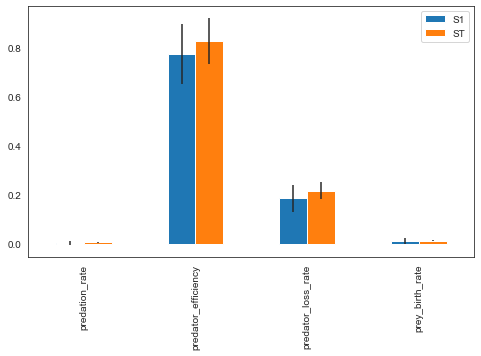

In [15]:
scores_filtered = {k:Si[k] for k in ['ST','ST_conf','S1','S1_conf']}
Si_df = pd.DataFrame(scores_filtered, index=problem['names'])

sns.set_style('white')
fig, ax = plt.subplots(1)

indices = Si_df[['S1','ST']]
err = Si_df[['S1_conf','ST_conf']]

indices.plot.bar(yerr=err.values.T,ax=ax)
fig.set_size_inches(8,6)
fig.subplots_adjust(bottom=0.3)
plt.show()


In [16]:
indices

,S1,ST
predation_rate,0.000661,0.005425
predator_efficiency,0.773630,0.828010
predator_loss_rate,0.184630,0.215999
prey_birth_rate,0.010348,0.010643


# Extra Trees

In [17]:
from SALib.analyze.sobol import analyze

In [18]:
sobol_results= {}
for policy in experiments.policy.unique():
    logical = experiments.policy == policy
    y= prey_mean[logical]
    indices=analyze(problem, y)
    sobol_results[policy] = indices

In [19]:
sobol_results

{'None': {'S1': array([6.60614808e-04, 7.73630208e-01, 1.84630497e-01, 1.03480193e-02]),
  'S1_conf': array([0.00842284, 0.10694416, 0.05631373, 0.01402997]),
  'ST': array([0.00542464, 0.82801021, 0.21599854, 0.01064252]),
  'ST_conf': array([0.00152763, 0.08905813, 0.03273321, 0.00193797]),
  'S2': array([[        nan, -0.00097873,  0.00285568, -0.00141365],
         [        nan,         nan,  0.03886788, -0.00615334],
         [        nan,         nan,         nan, -0.01406847],
         [        nan,         nan,         nan,         nan]]),
  'S2_conf': array([[       nan, 0.01721283, 0.01215387, 0.0121104 ],
         [       nan,        nan, 0.18546093, 0.15713987],
         [       nan,        nan,        nan, 0.09874139],
         [       nan,        nan,        nan,        nan]])}}

In [20]:
y={'prey': prey_mean}
#y_ST={"ST": indices['ST']}
#     'max. infected fraction': np.max(outcomes['infected fraction R1'], axis=1)}

In [21]:
scores=feature_scoring.get_feature_scores_all(x=experiments, y=y , mode=feature_scoring.RuleInductionType.REGRESSION, max_features=0.6, nr_trees=100, alg="extra trees")

[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category


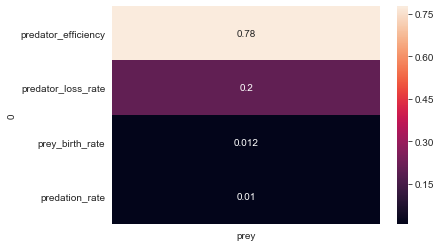

In [22]:
sns.heatmap(scores, annot=True)
plt.show()